In [309]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import gensim
import gensim.corpora as corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


In [310]:
data = pd.read_csv('assets/news_articles.csv')

In [311]:
data.head()

,id,title,content
0,25626,"One Weight-Loss Approach Fits All? No, Not Eve...","Dr. Frank Sacks, a professor of nutrition at H..."
1,19551,South Carolina Stuns Baylor to Reach the Round...,South Carolina’s win over Duke was not only ...
2,25221,"U.S. Presidential Race, Apple, Gene Wilder: Yo...",(Want to get this briefing by email? Here’s th...
3,18026,"His Predecessor Gone, Gambia’s New President F...","BANJUL, Gambia — A week after he was inaugu..."
4,21063,‘Harry Potter and the Cursed Child’ Goes From ...,The biggest book of the summer isn’t a blockbu...


In [312]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       100 non-null    int64 
 1   title    100 non-null    object
 2   content  100 non-null    object
dtypes: int64(1), object(2)
memory usage: 2.5+ KB


## Latent Dirichlet Allocation (LDA)

### Preprocessing text
Clean the data 📈 🧹

In [313]:
articles = data["content"]

In [314]:
# Lowercase and remove punctuation
articles = data['content'].str.lower().apply(lambda x: re.sub(r"([^\w\s])", "", x))
articles.head()

0    dr frank sacks a professor of nutrition at har...
1    south carolinas win over   duke was not only a...
2    want to get this briefing by email heres the  ...
3    banjul gambia     a week after he was inaugura...
4    the biggest book of the summer isnt a blockbus...
Name: content, dtype: object

In [315]:
# Remove stopwords
en_stopwords = stopwords.words("english")
articles = articles.apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))
articles.head()

0    dr frank sacks professor nutrition harvard lik...
1    south carolinas win duke surprise fans postgam...
2    want get briefing email heres good evening her...
3    banjul gambia week inaugurated another country...
4    biggest book summer isnt blockbuster thriller ...
Name: content, dtype: object

In [316]:
# Tokenize the articles
articles = articles.apply(lambda token: word_tokenize(token))
articles.head()

0    [dr, frank, sacks, professor, nutrition, harva...
1    [south, carolinas, win, duke, surprise, fans, ...
2    [want, get, briefing, email, heres, good, even...
3    [banjul, gambia, week, inaugurated, another, c...
4    [biggest, book, summer, isnt, blockbuster, thr...
Name: content, dtype: object

In [317]:
# Stemming
ps = PorterStemmer()
articles = articles.apply(lambda tokens: [ps.stem(token) for token in tokens])
articles.head()

0    [dr, frank, sack, professor, nutrit, harvard, ...
1    [south, carolina, win, duke, surpris, fan, pos...
2    [want, get, brief, email, here, good, even, he...
3    [banjul, gambia, week, inaugur, anoth, countri...
4    [biggest, book, summer, isnt, blockbust, thril...
Name: content, dtype: object

In [318]:
articles

0     [dr, frank, sack, professor, nutrit, harvard, ...
1     [south, carolina, win, duke, surpris, fan, pos...
2     [want, get, brief, email, here, good, even, he...
3     [banjul, gambia, week, inaugur, anoth, countri...
4     [biggest, book, summer, isnt, blockbust, thril...
                            ...                        
95    [want, get, brief, email, here, good, even, he...
96    [tallinn, estonia, guard, brought, ahm, abdul,...
97    [gov, scott, walker, wisconsin, activ, wiscons...
98    [social, media, shook, emot, headlin, shout, n...
99    [moment, joanna, acevedo, first, set, foot, bo...
Name: content, Length: 100, dtype: object

### Vectorization

In [319]:
dictionary = corpora.Dictionary(articles)
print(dictionary)

Dictionary<8693 unique tokens: ['10', '100', '108', '15', '155']...>


**Document-term matrix**: a table showing which words appear and how frequently they appear in each document (same idea to vectorization, specifically Bag-Of-Words). 

`doc2bow` - _"Document to bag of words"_

In [320]:
doc_term = [dictionary.doc2bow(text) for text in articles]
print(doc_term[0][0:10])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


In [321]:
num_topics = 2

lda_model = gensim.models.LdaModel(corpus = doc_term, id2word = dictionary, num_topics = num_topics)

print(lda_model.print_topics(num_topics = num_topics, num_words = 5))

[(0, '0.020*"mr" + 0.017*"said" + 0.005*"trump" + 0.005*"would" + 0.004*"state"'), (1, '0.013*"mr" + 0.012*"said" + 0.006*"trump" + 0.004*"one" + 0.004*"year"')]


#

## Latent Semantic Analysis

In [322]:
lsa_model = LsiModel(corpus=doc_term, num_topics = num_topics, id2word = dictionary)
print(lsa_model.print_topics(num_topics = num_topics, num_words = 5))

[(0, '0.615*"mr" + 0.429*"said" + 0.187*"trump" + 0.130*"state" + 0.119*"would"'), (1, '-0.537*"mr" + -0.319*"trump" + 0.286*"said" + 0.242*"saudi" + 0.142*"weight"')]


**DETERMINE NUMBER OF TOPICS**

In [323]:
coherence_values = []
model_list = []
min_topics = 2
max_topics = 11


for num_topics_i in range(min_topics, max_topics + 1):
    # Gives us a new model object.
    model = LsiModel(corpus = doc_term, num_topics = num_topics_i, id2word = dictionary, random_seed = 0)
    # "c_v" coherence is a popular coherence measure based on:
    # - a sliding window, 
    # - a one-set segmentation of the top words,
    # - and an indirect confirmation measure that uses 
    #   normalized pointwise mutual information (NPMI) and the cosine similarity.
    # Ultimately, it measures how often the top words actually appear in the documents.
    coherence_model = CoherenceModel(model = model, texts = articles, dictionary = dictionary, coherence = 'c_v')
    
    model_list.append(model)
    coherence_values.append(coherence_model.get_coherence())


print(coherence_values[0])
print(model_list[0])

0.37325067097153986
LsiModel<num_terms=8693, num_topics=2, decay=1.0, chunksize=20000>


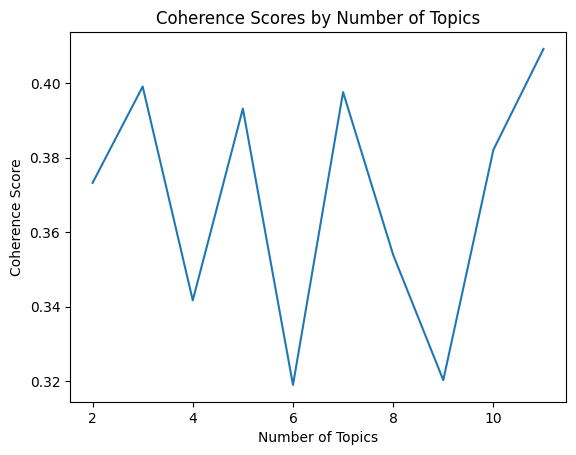

In [324]:
plt.plot(range(min_topics, max_topics + 1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores by Number of Topics")
plt.show()

Based on the graph above, 3 is point where the coherence score is the highest.

Therefore, the three topics give the most meaningful grouping of words.

In [325]:
final_n_topics = 3
lsamodel_f = LsiModel(corpus = doc_term, num_topics = final_n_topics, id2word = dictionary)
print(lsamodel_f.print_topics(num_topics = final_n_topics, num_words = 5))

[(0, '0.615*"mr" + 0.429*"said" + 0.187*"trump" + 0.130*"state" + 0.119*"would"'), (1, '-0.537*"mr" + -0.319*"trump" + 0.286*"said" + 0.242*"saudi" + 0.142*"weight"'), (2, '-0.460*"saudi" + -0.264*"taliban" + 0.249*"weight" + -0.194*"afghanistan" + 0.191*"dr"')]
